# Localización de fuentes

`
Autores:
Brigitte Aguilar, Sofía Poux, Elizabeth Young
`

Modificado de *PracticalMEEG2022: MNE-python hands-on tutorial*. Por Britta Westner. 


El propósito de este tutorial es aprender cómo computar y aplicar un método lineal inverso como MN/dSPM/sLORETA en datos evocados/épocas/crudos.

In [1]:

%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
import mne

mne.set_log_level('warning')

# Cambiar el siguiente path a la dirección en disco dónde se encuentran los datos
data_path = os.path.expanduser("~D:/Usuarios/Desktop/")
extra_path = os.path.expanduser("~D:/Usuarios/Downloads/extra_data_mne/")

raw_fname = os.path.join(data_path,
   'sub-01_ses-meg_task-facerecognition_run-01_proc-sss_meg.fif')
epochs_fname = raw_fname.replace('_meg.fif', '-epo.fif')



## Lectura de épocas y cómputo de ERP/ERF 

In [2]:
epochs = mne.read_epochs(epochs_fname)
epochs.info


<Info | 25 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG0113, MEG0112, MEG0111, MEG0122, MEG0123, MEG0121, MEG0132, ...
 chs: 204 Gradiometers, 102 Magnetometers, 70 EEG, 2 EOG
 custom_ref_applied: True
 description: (meg) Vectorview system at Cambridge
 dev_head_t: MEG device -> head transform
 dig: 137 items (3 Cardinal, 5 HPI, 75 EEG, 54 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 2 items (dict)
 line_freq: 50.0
 lowpass: 40.0 Hz
 meas_date: 1941-03-22 11:04:14 UTC
 meas_id: 4 items (dict)
 nchan: 378
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: dgw_studies
 projs: EOG-planar--0.200-0.200-PCA-01: on, EOG-axial-- ...
 sfreq: 300.0 Hz
 subject_info: 2 items (dict)
>

In [3]:
# Como calculamos el modelo Forward solo con los datos de EEG, vamos a descartar los de MEG.
epochs.pick_types(meg=False, eeg=True)

print(epochs)

<EpochsFIF |  145 events (all good), -0.5 – 2 s, baseline -0.2 – 0 s, ~64.8 MB, data loaded,
 'face/famous/first': 24
 'face/famous/immediate': 10
 'face/famous/long': 14
 'face/unfamiliar/first': 25
 'face/unfamiliar/immediate': 12
 'face/unfamiliar/long': 10
 'scrambled/first': 25
 'scrambled/immediate': 14
 'scrambled/long': 11>


In [4]:

# Para la localización de fuentes es necesario tener la referencia promedio.

epochs= mne.set_eeg_reference(epochs, ref_channels='average', projection= True) 
epochs=epochs[0]


Calculemos las respuestas evocadas por dos condiciones: _face_  y  _scrambled_

In [5]:
evoked_face = epochs['face'].average()
evoked_scrambled = epochs['scrambled'].average()

Contrastemos las dos condiciones:

C:\Users\FIUNER\AppData\Local\Temp\ipykernel_10960\2129049466.py:3: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  evoked_contrast.plot();


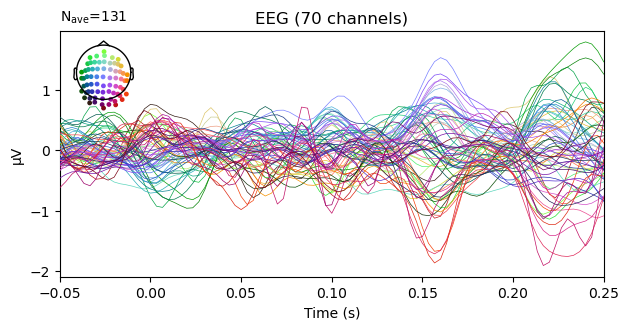

In [6]:
evoked_contrast = mne.combine_evoked([evoked_face, evoked_scrambled], [0.5, -0.5])
evoked_contrast.crop(-0.05, 0.25)
evoked_contrast.plot();

## Preparando el "beamforming" de los datos

Para la formación de los haces, necesitamos la  **matriz de covarianza de los datos**.

Dado que queremos contrastar condiciones, necesitaremos el llamado **common spatial filter**, lo que significa que usaremos la matriz de covarianza que fue computada para ambas condiciones en conjunto. En este caso, eso es para todos los datos.

In [7]:
data_cov = mne.compute_covariance(epochs, tmin=0., tmax=0.25,
                                  method='empirical', rank='info')

Visualicemos ahora nuestras matrices de covarianza. Vemos que tienen una severa deficiencia de rango. ¿Pueden adivinar por qué?

Tomemos una nota mental de que nos tenemos que ocupar de eso más tarde!

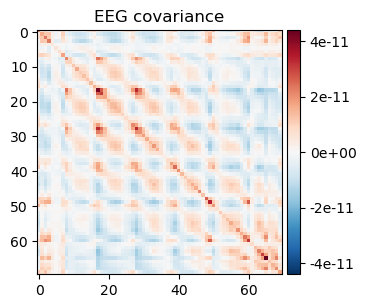

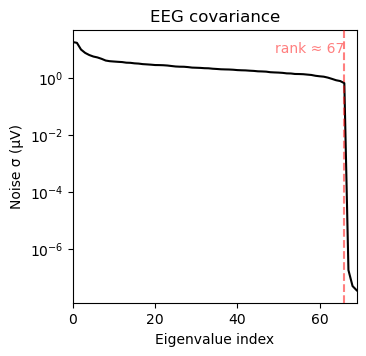

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [9]:
mne.viz.plot_cov(data_cov, info=epochs.info)

In [8]:
ranks = {'eeg': 67}  # Pasaremos el rango al "beamformer" luego

Since we have two sensor types that we want to combine (gradiometers and magnetometers), we also need to compute a noise covariance matrix. That will be used for pre-whitening the data, data covariance matrix, and forward model. This is needed to take care of the different orders of magnitudes of the sensor types.

O SEA QUE PARA EEG NO ES NECESARIA?

In [ ]:
# noise_cov = mne.compute_covariance(epochs, tmin=-.25, tmax=0.,  # use the baseline
#                                    method='empirical', 
#                                    rank='info')

Por último, también necesitamos el "forward model" que guardamos en el tutorial anterior

In [10]:
fwd_fname = os.path.join(extra_path,
    'source_recon/sub-01/prueba-eeg--fwd.fif')
fwd = mne.read_forward_solution(fwd_fname)

# Restrict forward solution to MEG channels only
fwd = mne.pick_types_forward(fwd, meg=False , eeg=True)

## Cálculo de "beamformer" y aplicación a los datos evocados

In [11]:
from mne.beamformer import make_lcmv, apply_lcmv

Ahora calcularemos el "beamformer":

In [12]:
filters = make_lcmv(
    epochs.info, fwd,
    data_cov=data_cov, noise_cov=None,
    pick_ori='max-power', rank=ranks
)

# noise_cov era igual a la matrz de covarianza que habían definido antes, pero como supuestamente no se necesita para EEG porque no tenés distintos tipos de sensores como en MEG

Podemos aplicar el filtro a una de nuestras condiciones para ver la activación que sigue a la presentación de una imagen:

In [13]:
stc_face = apply_lcmv(evoked=evoked_face, filters=filters)

Podemos graficar el cerebro y el curso temporal usando `stc_face.plot()`. Pueden explorar la reconstrucción de fuentes, por ejemplo mirando la activación como si fuera un video.  

Recortamos el objeto `stc` en el tiempo.

In [15]:
subjects_dir = os.path.join(extra_path, 'freesurfer')
stc_face.crop(-0.05, 0.25).plot(subjects_dir=subjects_dir, subject='fsaverage', hemi='both')

<div class="alert alert-success">
    <b>EJERCICIO</b>:
     <ul>
      <li>En la reconstrucción: ¿qué significan las activaciones positivas y negativas? </li>
    </ul>
</div>

Apliquemos el mismo filtro a nuestro contraste entre condiciones y grafiquemos:

In [17]:
%matplotlib qt
stc_contrast = apply_lcmv(evoked=evoked_contrast, filters=filters)
stc_contrast.plot(subjects_dir=subjects_dir, subject='fsaverage', hemi='both')

<div class="alert alert-success">
    <b>EJERCICIO</b>:
     <ul>
      <li>¿Las activaciones positivas y negativas significan lo mismo que antes?</li>
      <li>¿Pueden guarda una captura de pantalla de la actividad a 170 ms? </li>
    </ul>
</div>

## Preparándonos para la Estimación de Norma Mínima (Minimum Norm Estimation)

Para calcular nuestro operador inverso para nuestra estimación (minimum norm estimation), necesitamos una matriz de covarianza del ruido. Vamos a calcular la matriz de covarianza con diferentes métodos y vamos a dejar que el algoritmo elija la mejor!

Para más información, chequear:

Engemann DA & Gramfort A (2015): Automated model selection in covariance estimation and spatial whitening of MEG and EEG signals, NeuroImage. 

In [18]:
noise_cov = mne.compute_covariance(epochs, tmax=0.,
                                   method=['shrunk', 'empirical'],
                                   rank='info')
noise_cov['method']

'shrunk'

Podemos visualizar el blanqueo de los datos evocados, usando la matriz de covarianza del ruido:

C:\Users\FIUNER\AppData\Local\Temp\ipykernel_10960\2720967182.py:2: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  evoked_contrast.plot_white(noise_cov);


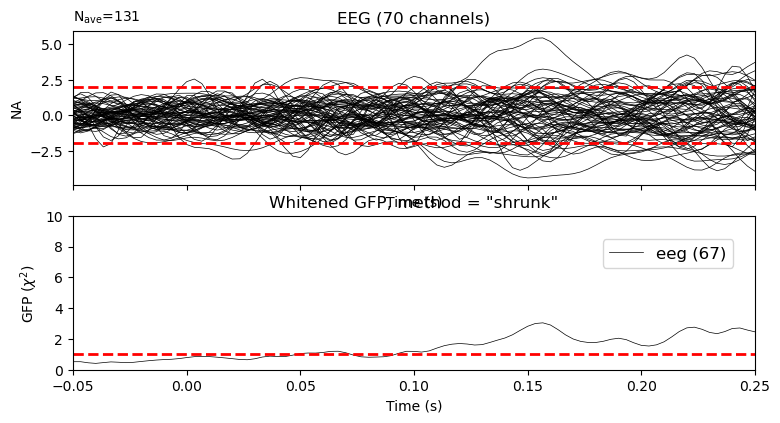

In [19]:
%matplotlib inline
evoked_contrast.plot_white(noise_cov);

Para la solución de fuentes de MNE, queremos usar un operador "forward" fijo: 

In [20]:
fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True)

## Cómputo del operador inverso y aplicación a los datos evocados

In [21]:
from mne.minimum_norm import (make_inverse_operator, apply_inverse)

Los Modelos Inversos de Norma Mínima son independientes de los datos (ya que usan la covarianza del ruido, pero no la matriz de covarianza de los datos) y por lo tanto pueden ser pre-computados y aplicados a los datos en una etapa tardía.

No necesitamos tener especial cuidado de nuestras condiciones en este punto.


In [22]:
info = evoked_contrast.info
inverse_operator = make_inverse_operator(info, fwd_fixed, noise_cov,
                                         loose=0.2, depth=0.8)

Apliquemos ahora nuestro operador inverso a nuestros datos evocados de contraste: 

In [23]:
method = "dSPM"
snr = 3.
lambda2 = 1. / snr ** 2  # regularización
stc = apply_inverse(evoked_contrast, inverse_operator, lambda2,
                    method=method, pick_ori=None)
print(stc)

<SourceEstimate | 8196 vertices, subject : fsaverage, tmin : -50.0 (ms), tmax : 250.00000000000006 (ms), tstep : 3.3333333333333335 (ms), data shape : (8196, 91), ~5.8 MB>


Grafiquemos los resultados como hicimos antes con el beamformer:

In [24]:
subjects_dir = os.path.join(extra_path, 'freesurfer')
stc.plot(hemi='both', subjects_dir=subjects_dir, subject='fsaverage')

## Unificándo los datos a un cerebro promedio para estudio de grupos

Dependiendo de tu instalación de MNE-Python, esto podría descargar los datos de *fsaverage*. Esto podría demorar un rato.

In [25]:
mne.datasets.fetch_fsaverage(subjects_dir=subjects_dir)

'D:\\Usuarios\\Downloads\\extra_data_mne\\freesurfer\\fsaverage'

In [26]:
morph = mne.compute_source_morph(stc, subject_from='fsaverage',
                                 subject_to='fsaverage',
                                 subjects_dir=subjects_dir)
stc_fsaverage = morph.apply(stc)

In [27]:
stc_fsaverage.plot(surface='inflated', hemi='both',
                   subjects_dir=subjects_dir)


<div class="alert alert-success">
    <b>EJERCICIO</b>:
     <ul>
      <li>Correr sLORETA sobre los mismos datos y comparar la localización de fuentes. </li>
    </ul>
</div>
